Fetch information about a specific person identified by his/her ORCID ID, and handle API errors.

[Download Notebook](https://github.com/researchgraph/augment-api-beta/blob/main/docs/notebooks/publications.ipynb)

In [91]:
import sys
sys.path.append('../')

# !{sys.executable} -m pip install wordcloud

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import altair as alt
import networkx as nx
import nx_altair as nxa
from wordcloud import WordCloud, STOPWORDS 
import pandas as pd
from datetime import datetime, date
import requests
import json

import os
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv();

### ORCID ID not found

In [92]:
# ORCID ID not found
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0003-XXXX-XXXX"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 400:
    print(r.json()["message"])

Augment API query complete  400
FAILED: Invalid ORCID 0000-0003-XXXX-XXXX


### Missing API_KEY

In [93]:
# Missing API_KEY
API_KEY = ''
ORCID = "0000-0002-0715-6126"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 401:
    print(f'Authentication error.')

Augment API query complete  401
Authentication error.


### ORCID ID does exist

In [94]:
# ORCID ID does exist
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0002-0068-716X"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 200 and r.json()[0]["nodes"]["researchers"]:    
    researchers = r.json()[0]["nodes"]["researchers"]
    
    researcher = None
    for i in range(len(researchers)):
        if researchers[i]["orcid"] == ORCID:
            researcher = researchers[i]

print()
print(f'ORCID: {researcher["orcid"]}')
print(f'First name: {researcher["first_name"]}')
print(f'Last name: {researcher["last_name"]}')
print()
print(f'The researcher {researcher["full_name"]} is connected to {r.json()[0]["stats"]}.')

Augment API query complete  200

ORCID: 0000-0002-0068-716X
First name: Cameron
Last name: Neylon

The researcher Cameron Neylon is connected to {'datasets': 0, 'grants': 0, 'organisations': 207, 'publications': 157, 'researchers': 126}.


### List of publications
Only includes publications with DOIs, and duplicate versions removed, sorted by publication year in descending order

In [95]:
# include all publications
pd.set_option("display.max_rows", None)

df = pd.DataFrame(r.json()[0]["nodes"]["publications"], columns=['doi', 'publication_year', 'title'])
df = df.dropna()
df = df[df['publication_year'] != 9999]
df = df.drop_duplicates(subset=['publication_year', 'title'])
df = df.sort_values(by=['publication_year','doi'], ascending=False)
dfStyler = df.style.set_properties(**{'text-align': 'left'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,doi,publication_year,title
136,10.7717/peerj.11391,2021,Mapping open knowledge institutions: an exploratory analysis of Australian universities
64,10.5281/zenodo.4893802,2021,An Open Knowledge Base for the Netherlands: Report of a Community Workshop
115,10.5281/zenodo.4680985,2021,A Tale of Two Societies
92,10.5281/zenodo.4663353,2021,Reading Peer Review – What a dataset of peer review reports can teach us about changing research culture
124,10.1007/978-3-030-71305-8_36,2021,"Becoming Open Knowledge Institutions: Divergence, Dialogue and Diversity"
121,10.7554/elife.57067,2020,Meta-Research: Evaluating the impact of open access policies on research institutions
33,10.6084/m9.figshare.13010000.v1,2020,The State of Altmetrics: A tenth anniversary celebration
34,10.6084/m9.figshare.13010000,2020,The state of altmetrics: a tenth anniversary celebration
72,10.5281/zenodo.4040402,2020,Codes and data for the analysis of open knowledge institution indicators: an Australian case study
47,10.5281/zenodo.3693222,2020,"Data and Intermediate Queries for: Evaluating institutional open access performance: Methodology, challenges and assessment"


### Publications by year

In [96]:
yf = df['publication_year'].groupby(df['publication_year']).agg('count').reset_index(name ='count')
ef = pd.DataFrame([[1998, 0],[1999, 0],[2001, 0],[2002, 0], [2003, 0]], columns=['publication_year', 'count'])
yf = yf.append(ef, ignore_index=True)
print(yf)
plot_title = alt.TitleParams(f'{researcher["full_name"]} (ORCID {ORCID})', subtitle=['Publications by Year'])
alt.Chart(yf, title=plot_title).mark_bar(color='green').properties(width=500).encode(
    alt.X("publication_year:O", axis=alt.Axis(title='Publication Year', labelAngle=-45)),
    alt.Y("count", axis=alt.Axis(title=None))
).configure_header(
    titleColor='green',
    titleFontSize=18,
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

   publication_year  count
0              1997      1
1              2000      1
2              2004      2
3              2005      4
4              2006      1
5              2007      3
6              2008      8
7              2009      7
8              2011     13
9              2012      8
10             2013     18
11             2014      6
12             2015      2
13             2016      6
14             2017     20
15             2018      7
16             2019      6
17             2020     13
18             2021      5
19             1998      0
20             1999      0
21             2001      0
22             2002      0
23             2003      0


alt.Chart(...)

### Topics of publications

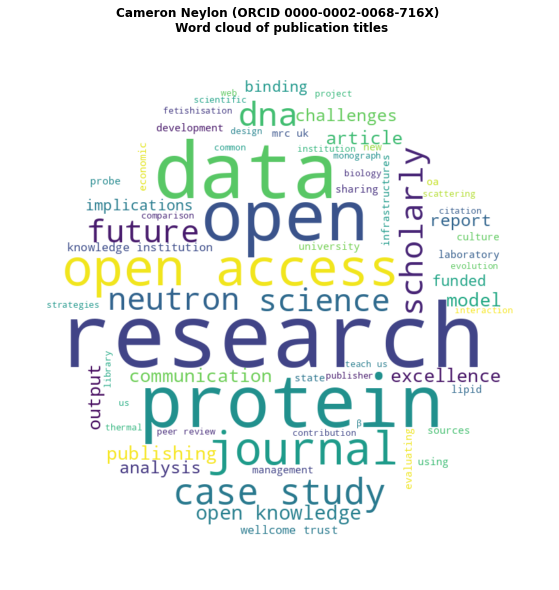

In [97]:
stopWords = set(STOPWORDS)
stopWords.add('_')

titleWords=[]
for index, row in df.iterrows():
    tokens = [t.lower() for t in row['title'].split()]     
    titleWords += tokens
     
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
mask = 255 * mask.astype(int)
    
wordcloud = WordCloud(width = 600, height = 600,
            max_words = 100,
            background_color ='white', 
            stopwords = stopWords, 
            min_font_size = 12, 
            mask = mask).generate(" ".join(titleWords))
    
fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = None)
ax.set_title(f'{researcher["full_name"]} (ORCID {researcher["orcid"]}) \n Word cloud of publication titles', fontsize=12, fontweight="semibold")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()